Описание датасета

GA Sessions
Одна строка = один визит на сайт.
Описание атрибутов:
- session_id — ID визита;
- client_id — ID посетителя;
- visit_date — дата визита;
- visit_time — время визита;
- visit_number — порядковый номер визита клиента;
- utm_source — канал привлечения;
- utm_medium — тип привлечения;
- utm_campaign — рекламная кампания;
- utm_keyword — ключевое слово;
- device_category — тип устройства;
- device_os — ОС устройства;
- device_brand — марка устройства;
- device_model — модель устройства;
- device_screen_resolution — разрешение экрана;
- device_brand — марка устройства;
- device_model — модель устройства;
- device_screen_resolution — разрешение экрана;
- device_browser — браузер;
- geo_country — страна;
- geo_city — город.

GA Hits

- session_id — ID визита;
- hit_date — дата события;
- hit_time — время события;
- hit_number — порядковый номер события в рамках сессии;
- hit_type — тип события;
- hit_referer — источник события;
- hit_page_path — страница события;
- event_category — тип действия;
- event_action — действие;
- event_label — тег действия;
- event_value — значение результата действия.

## 0 - Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import datetime

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from tqdm.notebook import tqdm
from scipy.stats import entropy
from sklearn.manifold import TSNE, MDS

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix
from plot_metric.functions import BinaryClassification

from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")
from typing import List, NewType
EntropyCategoricalEmbedderObject = NewType('EntropyCategoricalEmbedderObject', object) #creating new type to annotate in our class

## 1 - Load file

In [3]:
df_sessions = pd.read_csv("data/ga_sessions.csv")

In [2]:
df_hits = pd.read_csv("data/ga_hits.csv")

In [4]:
df_sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 18 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   session_id                object
 1   client_id                 object
 2   visit_date                object
 3   visit_time                object
 4   visit_number              int64 
 5   utm_source                object
 6   utm_medium                object
 7   utm_campaign              object
 8   utm_adcontent             object
 9   utm_keyword               object
 10  device_category           object
 11  device_os                 object
 12  device_brand              object
 13  device_model              object
 14  device_screen_resolution  object
 15  device_browser            object
 16  geo_country               object
 17  geo_city                  object
dtypes: int64(1), object(17)
memory usage: 255.4+ MB


In [5]:
df_hits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726470 entries, 0 to 15726469
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   session_id      object 
 1   hit_date        object 
 2   hit_time        float64
 3   hit_number      int64  
 4   hit_type        object 
 5   hit_referer     object 
 6   hit_page_path   object 
 7   event_category  object 
 8   event_action    object 
 9   event_label     object 
 10  event_value     float64
dtypes: float64(2), int64(1), object(8)
memory usage: 1.3+ GB


In [3]:
df_sessions.head(5)

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.163687,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.162225,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.162225,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow


In [3]:
df_hits.head(5)

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,NaN
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,NaN


## 2 - Data Preparation

В задаче нам надо предсказать факт совершения пользователем целевого действия при этом на вход модели будут приходить
фичи  utm_*, device_*, geo_*, поэтому:

1) Необходимо извлечь из таблицы hits факт целевого действия привязанного к session_id.

2) В такой модели не учитываются сессии пользователя, так как фичи visit в модель поступать не будет, поэтому
необходимо привязать факт совершения целевого действия session_id к client_id.
    
3) Предварительная подготовка датасета будет заключаться в сопоставлении сессий и клиентов, извлекем из таблицы hits данные
совершил клиент целевое действие или нет. Так как на вход модели будут поступать только текущие utm_*, device_*, geo_* фичи,
обратиться к таблице hits и посмотреть историю действий клиента мы не сможем, поэтому не имеет смысла создавать из них новые
фичи.

    
4) После удаления дубликатов датасет уменьшится и это облегчит задачу заполнения пропусков. Заполним пропуски
и удалим пустые фичи.

### 2.0 - Preprocessing

In [14]:
def target_action(df):
        if df['event_action'] == 'sub_car_claim_click':
            return 1
        elif df['event_action'] == 'sub_car_claim_submit_click':
            return 1
        elif df['event_action'] == 'sub_open_dialog_click':
            return 1
        elif df['event_action'] == 'sub_custom_question_submit_click':
            return 1
        elif df['event_action'] == 'sub_call_number_click':
            return 1
        elif df['event_action'] == 'sub_callback_submit_click':
            return 1
        elif df['event_action'] == 'sub_submit_success':
            return 1
        elif df['event_action'] == 'sub_car_request_submit_click':
            return 1
        else:
            return 0

In [15]:
df_hits['y'] = df_hits.apply(target_action,
                                 axis=1)  # отмечаем на датасете действия, в которых клиенты совершили target

In [17]:
df_hits['len_path'] = df_hits['hit_page_path'].apply(lambda x: len(x))
df_hits

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value,y,len_path
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN,0,544
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN,0,176
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN,0,534
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,NaN,0,544
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,NaN,0,78
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15726465,6866159858916559617.1640270865.1640270865,2021-12-23,810589.0,43,event,NaN,sberauto.com/cars/all/toyota/fortuner/24cb5af2...,quiz,quiz_show,NaN,NaN,0,534
15726466,7310304587364460692.1640261783.1640261783,2021-12-23,904927.0,40,event,NaN,sberauto.com/cars/all/mercedes-benz/gla-klasse...,quiz,quiz_show,NaN,NaN,0,543
15726467,8013702685784312179.1640270195.1640270195,2021-12-23,2172865.0,43,event,NaN,sberauto.com/cars/all/toyota/alphard/2ebe4871?...,quiz,quiz_show,NaN,NaN,0,214
15726468,8021505554734405918.1640257821.1640257821,2021-12-23,713325.0,45,event,NaN,sberauto.com/cars/all/bmw/x3/6a660f0a?rental_p...,quiz,quiz_show,NaN,NaN,0,60


In [24]:
df_hits[df_hits.y == 1].len_path.median()

65.0

In [26]:
df_hits[df_hits.y == 1].len_path.mean()

132.13293552445953

In [25]:
df_hits[df_hits.y == 0].len_path.median()

79.0

In [27]:
df_hits[df_hits.y == 0].len_path.mean()

148.75746016947602

длина hit_page_path у y==1 и у y==0 в среднем значительно различаются. Можно использовать как фича

In [28]:
df_hits[df_hits.y == 1].hit_number.median()

22.0

In [29]:
df_hits[df_hits.y == 1].hit_number.mean()

31.632392191253288

In [30]:
df_hits[df_hits.y == 0].hit_number.median()

15.0

In [31]:
df_hits[df_hits.y == 0].hit_number.mean()

23.512983976890403

номер визита у y==1 и у y==0 в среднем значительно различаются. Можно использовать как фича

In [47]:
df_hits['hit_day'] = pd.to_datetime(df_hits['hit_date'])

In [48]:
df_hits['hit_day'] = df_hits['hit_day'].apply(lambda x: x.weekday())
df_hits

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value,y,len_path,hit_day
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN,0,544,3
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN,0,176,3
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN,0,534,3
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,NaN,0,544,3
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,NaN,0,78,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15726465,6866159858916559617.1640270865.1640270865,2021-12-23,810589.0,43,event,NaN,sberauto.com/cars/all/toyota/fortuner/24cb5af2...,quiz,quiz_show,NaN,NaN,0,534,3
15726466,7310304587364460692.1640261783.1640261783,2021-12-23,904927.0,40,event,NaN,sberauto.com/cars/all/mercedes-benz/gla-klasse...,quiz,quiz_show,NaN,NaN,0,543,3
15726467,8013702685784312179.1640270195.1640270195,2021-12-23,2172865.0,43,event,NaN,sberauto.com/cars/all/toyota/alphard/2ebe4871?...,quiz,quiz_show,NaN,NaN,0,214,3
15726468,8021505554734405918.1640257821.1640257821,2021-12-23,713325.0,45,event,NaN,sberauto.com/cars/all/bmw/x3/6a660f0a?rental_p...,quiz,quiz_show,NaN,NaN,0,60,3


In [56]:
df_hits[df_hits.y == 1].hit_day.value_counts(normalize=True)

1    0.177231
0    0.175907
2    0.155956
3    0.153201
4    0.131306
5    0.104377
6    0.102023
Name: hit_day, dtype: float64

In [57]:
df_hits[df_hits.y == 0].hit_day.value_counts(normalize=True)

0    0.168343
1    0.165963
3    0.146427
2    0.143960
4    0.141510
6    0.119248
5    0.114549
Name: hit_day, dtype: float64

Чаще всего клиенты во вторник совершали целевое действие, а в понедельник чаще всего не совершали

In [82]:
df_hits["hit_time"] = df_hits["hit_time"].fillna(000000.0)

In [87]:
df_hits["time"] = df_hits["hit_time"].apply(lambda x: datetime.datetime.fromtimestamp(float('0000' + str(x))).hour)
df_hits

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value,y,len_path,hit_day,time
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN,0,544,3,1
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN,0,176,3,0
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN,0,534,3,8
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,NaN,0,544,3,22
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,NaN,0,78,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15726465,6866159858916559617.1640270865.1640270865,2021-12-23,810589.0,43,event,NaN,sberauto.com/cars/all/toyota/fortuner/24cb5af2...,quiz,quiz_show,NaN,NaN,0,534,3,12
15726466,7310304587364460692.1640261783.1640261783,2021-12-23,904927.0,40,event,NaN,sberauto.com/cars/all/mercedes-benz/gla-klasse...,quiz,quiz_show,NaN,NaN,0,543,3,14
15726467,8013702685784312179.1640270195.1640270195,2021-12-23,2172865.0,43,event,NaN,sberauto.com/cars/all/toyota/alphard/2ebe4871?...,quiz,quiz_show,NaN,NaN,0,214,3,6
15726468,8021505554734405918.1640257821.1640257821,2021-12-23,713325.0,45,event,NaN,sberauto.com/cars/all/bmw/x3/6a660f0a?rental_p...,quiz,quiz_show,NaN,NaN,0,60,3,9


In [88]:
df_hits[df_hits.y == 1].time.value_counts(normalize=True)

3     0.664611
4     0.020246
5     0.019331
6     0.017549
9     0.016090
7     0.015757
8     0.015518
11    0.014975
10    0.014956
12    0.014737
19    0.014336
18    0.014193
15    0.013946
14    0.013822
16    0.013784
13    0.013688
17    0.013593
23    0.013116
20    0.013011
21    0.012983
2     0.012554
22    0.012506
0     0.012392
1     0.012306
Name: time, dtype: float64

In [89]:
df_hits[df_hits.y == 0].time.value_counts(normalize=True)

3     0.657877
4     0.022501
5     0.018365
6     0.016592
7     0.016233
8     0.015970
10    0.015914
9     0.015821
12    0.015638
11    0.015593
13    0.015379
14    0.015093
15    0.014844
16    0.014673
17    0.014374
18    0.013932
19    0.013703
20    0.013390
21    0.013083
22    0.012728
23    0.012510
0     0.012106
1     0.011944
2     0.011735
Name: time, dtype: float64

возьмем столбец time для определения разницы времени от начала сессии до совершения целевого действия

In [90]:
df_1 = df_hits[df_hits['y'] == 1].copy()  # отделим действия target от остальных

In [91]:
df_0 = df_hits[df_hits['y'] == 0].copy()

Удалим дубликаты сессий target, так как если клиент совершил несколько target, то они приравниваются к одному target.
Оставим только первое ключевое действие отсортированное по hit_time в датафрейме df_1.
Оставим последнее действие отсортированное по hit_time в датафрейме df_0.

In [94]:
df_1 = df_1.sort_values(by=['hit_date', 'hit_time'])
df_1

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value,y,len_path,hit_day,time
4191089,6210688458720252945.1621412493.1621412493,2021-05-19,0.0,77,event,HbolMJUevblAbkHClEQa,/cars?rental_car=rental_only,sub_submit,sub_submit_success,yrNVHowDbZsxjfjrrhyG,NaN,1,28,2,3
4191090,6210688458720252945.1621412493.1621412493,2021-05-19,0.0,63,event,HbolMJUevblAbkHClEQa,/cars/3369616c,sub_submit,sub_submit_success,uimgZZmhfLQwbKAZZfCk,NaN,1,14,2,3
4191091,6928943184024521318.1621445221.1621445221,2021-05-19,0.0,44,event,HbolMJUevblAbkHClEQa,/podpiska/,sub_submit,sub_submit_success,uimgZZmhfLQwbKAZZfCk,NaN,1,10,2,3
4191092,6928943184024521318.1621445221.1621445221,2021-05-19,0.0,47,event,HbolMJUevblAbkHClEQa,/podpiska/,sub_submit,sub_submit_success,KuMiABMMbspIDDhiCNVS,NaN,1,10,2,3
4191093,6210688458720252945.1621412493.1621412493,2021-05-19,0.0,71,event,HbolMJUevblAbkHClEQa,/cars?rental_car=rental_only,sub_submit,sub_submit_success,KuMiABMMbspIDDhiCNVS,NaN,1,28,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14262590,7617336337473895624.1640922312.1640922312,2021-12-31,2925081.0,95,event,NaN,sberauto.com/cars/all/haval/jolion/4930b1ba?ut...,sub_button_click,sub_car_claim_click,EsLbNNEnCkXWoaesnKlS,NaN,1,236,4,23
1343131,7617336337473895624.1640922312.1640922312,2021-12-31,3064911.0,96,event,NaN,sberauto.com/cars/all/haval/jolion/4930b1ba?ut...,sub_button_click,sub_open_dialog_click,ZaZuwAXOKlbzyhUqtnmk,NaN,1,236,4,14
3588394,7617336337473895624.1640922312.1640922312,2021-12-31,3084724.0,97,event,NaN,sberauto.com/cars/all/haval/jolion/4930b1ba?ut...,sub_button_click,sub_car_claim_click,EsLbNNEnCkXWoaesnKlS,NaN,1,236,4,19
14823366,7617336337473895624.1640922312.1640922312,2021-12-31,3106720.0,98,event,NaN,sberauto.com/cars/all/haval/jolion/4930b1ba?ut...,sub_button_click,sub_car_claim_submit_click,NaN,NaN,1,236,4,1


In [95]:
df_0 = df_0.sort_values(by=['hit_date', 'hit_time'])
df_0

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value,y,len_path,hit_day,time
4186001,4139574298519950329.1621415430.1621415430,2021-05-19,0.0,85,event,HbolMJUevblAbkHClEQa,/cars/23c13ad6,card_web,photos,KclpemfoHstknWHFiLit,NaN,0,14,2,3
4186002,4827459022311709456.1621416719.1621416719,2021-05-19,0.0,44,event,HbolMJUevblAbkHClEQa,/cars/3d299798,card_web,photos,KclpemfoHstknWHFiLit,NaN,0,14,2,3
4186003,9017082714844891185.1621428278.1621428278,2021-05-19,0.0,43,event,HbolMJUevblAbkHClEQa,/cars/bc590a82,card_web,photos,KclpemfoHstknWHFiLit,NaN,0,14,2,3
4186004,6732187674178020488.1621419144.1621419144,2021-05-19,0.0,52,event,HbolMJUevblAbkHClEQa,/cars/76782d54,card_web,photos,KclpemfoHstknWHFiLit,NaN,0,14,2,3
4186005,2481251803076051719.1621443350.1621443350,2021-05-19,0.0,47,event,HbolMJUevblAbkHClEQa,/cars/67d347e7,card_web,photos,KclpemfoHstknWHFiLit,NaN,0,14,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14263882,2024468888560773554.1640937558.1640937558,2021-12-31,3778630.0,44,event,NaN,sberauto.com/cars/all/skoda/rapid/bf24b977?ren...,card_web,view_new_card,NaN,NaN,0,65,4,20
782678,2024468888560773554.1640937558.1640937558,2021-12-31,3778631.0,46,event,NaN,sberauto.com/cars/all/skoda/rapid/bf24b977?ren...,card_web,view_new_card,NaN,NaN,0,65,4,20
2468248,2024468888560773554.1640937558.1640937558,2021-12-31,3778631.0,45,event,NaN,sberauto.com/cars/all/skoda/rapid/bf24b977?ren...,card_web,view_card,NaN,NaN,0,65,4,20
217533,1719912895044858538.1640943678.1640943678,2021-12-31,4683634.0,26,event,NaN,sberauto.com/cars?city=1&city=18&rental_car=re...,search_form,search_form_region,jaHkeGOvenXPkPYRHRsd,NaN,0,564,4,8


In [96]:
df_1 = df_1.drop_duplicates(subset=['session_id'], keep='first')

In [97]:
df_0 = df_0.drop_duplicates(subset=['session_id'], keep='last')

In [99]:
df_1.shape

(50760, 15)

In [100]:
df_0.shape

(1733988, 15)

In [101]:
df_sessions.shape

(1860042, 18)

объединим датайфеймы с сохранением индексов y==1

In [105]:
df_1 = df_1.set_index('session_id')
df_0 = df_0.set_index('session_id')

In [117]:
df_action = pd.concat((df_1, df_0), axis =0, ignore_index=False)
df_action

,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value,y,len_path,hit_day,time
session_id,,,,,,,,,,,,,,
6210688458720252945.1621412493.1621412493,2021-05-19,0.0,77,event,HbolMJUevblAbkHClEQa,/cars?rental_car=rental_only,sub_submit,sub_submit_success,yrNVHowDbZsxjfjrrhyG,NaN,1,28,2,3
6928943184024521318.1621445221.1621445221,2021-05-19,0.0,44,event,HbolMJUevblAbkHClEQa,/podpiska/,sub_submit,sub_submit_success,uimgZZmhfLQwbKAZZfCk,NaN,1,10,2,3
699724189311238385.1621426418.1621426418,2021-05-19,0.0,41,event,HbolMJUevblAbkHClEQa,/podpiska/,sub_submit,sub_submit_success,KuMiABMMbspIDDhiCNVS,NaN,1,10,2,3
865775708103066646.1621443607.1621443607,2021-05-19,0.0,4,event,HbolMJUevblAbkHClEQa,/podpiska/,sub_submit,sub_submit_success,uimgZZmhfLQwbKAZZfCk,NaN,1,10,2,3
4695010885262206557.1621452381.1621452381,2021-05-19,0.0,7,event,HbolMJUevblAbkHClEQa,/,sub_submit,sub_submit_success,uimgZZmhfLQwbKAZZfCk,NaN,1,1,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7617336337473895624.1640922312.1640922312,2021-12-31,3139173.0,105,event,wUCoZLVmUdqHAkustUwq,podpiska.sberauto.com/,sub_page_view,sub_landing,NaN,NaN,0,22,4,10
2024468888560773554.1640943362.1640943362,2021-12-31,3173199.0,77,event,NaN,sberauto.com/cars/all/toyota/camry/f28947a1?re...,card_web,view_new_card,NaN,NaN,0,66,4,20
8144003459444750055.1640942059.1640942059,2021-12-31,3686108.0,90,event,NaN,sberauto.com/cars?utm_source_initial=sbol&utm_...,quiz,quiz_show,NaN,NaN,0,169,4,18


In [118]:
len(df_action.index.unique())

1734610

уникальных индексов меньше, значит присутствуют дубликаты. Удалим дубликаты с сохранением первых, так как y==1 стоит в начале
датафрейма они сохранятся

In [120]:
df_action = df_action.reset_index().drop_duplicates(subset='session_id',keep='first').set_index('session_id')
df_action.shape

(1734610, 14)

In [121]:
len(df_action[df_action.y == 1])

50760

все сессии у==1 сохранились, дубликаты удалены

In [123]:
len(df_sessions.session_id.unique())

1860042

In [124]:
len(df_hits.session_id.unique())

1734610

почему то сессий изначально меньше

оставим только колонки, которые учавствуют в модели

In [125]:
df_action = df_action[['hit_number', 'len_path', 'hit_day', 'time', 'y']]
df_action

,hit_number,len_path,hit_day,time,y
session_id,,,,,
6210688458720252945.1621412493.1621412493,77,28,2,3,1
6928943184024521318.1621445221.1621445221,44,10,2,3,1
699724189311238385.1621426418.1621426418,41,10,2,3,1
865775708103066646.1621443607.1621443607,4,10,2,3,1
4695010885262206557.1621452381.1621452381,7,1,2,3,1
...,...,...,...,...,...
2062443902770545334.1640956598.1640956598,124,65,4,0,0
2024468888560773554.1640943362.1640943362,77,66,4,20,0
8144003459444750055.1640942059.1640942059,90,169,4,18,0


сохраним в файле промежуточную таблицу

In [126]:
df_action.to_csv('data/df_action.csv')

In [4]:
df_action = pd.read_csv('data/df_action.csv', index_col = 'session_id')
df_action

,hit_number,len_path,hit_day,time,y
session_id,,,,,
6210688458720252945.1621412493.1621412493,77,28,2,3,1
6928943184024521318.1621445221.1621445221,44,10,2,3,1
699724189311238385.1621426418.1621426418,41,10,2,3,1
865775708103066646.1621443607.1621443607,4,10,2,3,1
4695010885262206557.1621452381.1621452381,7,1,2,3,1
...,...,...,...,...,...
2062443902770545334.1640956598.1640956598,124,65,4,0,0
2024468888560773554.1640943362.1640943362,77,66,4,20,0
8144003459444750055.1640942059.1640942059,90,169,4,18,0


In [6]:
df_sessions = df_sessions.set_index('session_id')

In [7]:
df_sessions['hit_number'] = df_action['hit_number']
df_sessions['hit_len_path'] = df_action['len_path']
df_sessions['hit_day'] = df_action['hit_day']
df_sessions['hit_hour'] = df_action['time']
df_sessions['y'] = df_action['y']
df_sessions

,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,...,device_model,device_screen_resolution,device_browser,geo_country,geo_city,hit_number,hit_len_path,hit_day,hit_hour,y
session_id,,,,,,,,,,,,,,,,,,,,,
9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,...,NaN,360x720,Chrome,Russia,Zlatoust,4.0,22.0,2.0,15.0,0.0
905544597018549464.1636867290.1636867290,210838531.163687,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,...,NaN,385x854,Samsung Internet,Russia,Moscow,3.0,22.0,6.0,3.0,0.0
9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,...,NaN,360x720,Chrome,Russia,Krasnoyarsk,20.0,212.0,1.0,11.0,0.0
9055447046360770272.1622255328.1622255328,2108385564.162225,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,...,NaN,393x786,Chrome,Russia,Moscow,7.0,22.0,5.0,3.0,0.0
9055447046360770272.1622255345.1622255345,2108385564.162225,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,...,NaN,393x786,Chrome,Russia,Moscow,2.0,79.0,5.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9055415581448263752.1640159305.1640159305,2108378238.164016,2021-12-22,10:48:25,1,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,VlqBmecIOXWjCWUmQkLd,desktop,...,NaN,1920x1080,Chrome,Russia,Moscow,4.0,48.0,2.0,7.0,0.0
9055421130527858185.1622007305.1622007305,2108379530.162201,2021-05-26,08:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,...,NaN,390x844,Safari,Russia,Stavropol,12.0,49.0,2.0,3.0,0.0
9055422955903931195.1636979515.1636979515,2108379955.163697,2021-11-15,15:31:55,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,...,NaN,375x667,Safari,Russia,Moscow,59.0,71.0,0.0,8.0,0.0


разделим df_sessions датасет на два датасета - сессии где клиент совершил целевое target и не совершил

In [10]:
df_sessions_1 = df_sessions[df_sessions.y == 1]
df_sessions_0 = df_sessions[df_sessions.y == 0]

удалим сессии в обоих датасетах по client_id, оставим в датасетах только информацию совершил клиент target или нет
причем в df_sessions_1 оставим первую сессию, а в df_sessions_0 останется последняя сессия target = 0

In [11]:
df_sessions_1 = df_sessions_1.drop_duplicates(subset=['client_id'], keep='first')
df_sessions_0 = df_sessions_0.drop_duplicates(subset=['client_id'], keep='last')
df_sessions_y = df_sessions_1.append(df_sessions_0)  # объединим датасеты, вверху будут target = 1
df_sessions_y

,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,...,device_model,device_screen_resolution,device_browser,geo_country,geo_city,hit_number,hit_len_path,hit_day,hit_hour,y
session_id,,,,,,,,,,,,,,,,,,,,,
9055768928391199041.1623652678.1623652678,2108460508.162365,2021-06-14,09:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,...,NaN,360x780,Chrome,Russia,Moscow,11.0,49.0,0.0,3.0,1.0
9055789093275396095.1636395007.1636395007,2108465203.16364,2021-11-08,21:10:07,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,...,NaN,414x736,Safari,Russia,Samara,26.0,153.0,0.0,7.0,1.0
9055794766915104430.1624305327.1624305327,2108466524.16243,2021-06-21,22:00:00,1,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,NaN,desktop,...,NaN,834x1112,Safari,Russia,Domodedovo,55.0,79.0,0.0,3.0,1.0
9056028189803556573.1630154471.1630154471,2108520872.163016,2021-08-28,15:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,...,NaN,412x915,YaBrowser,Russia,Krasnodar,19.0,49.0,5.0,3.0,1.0
9056093322981390023.1628944098.1628944098,2108536037.162894,2021-08-14,15:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,...,NaN,360x740,Chrome,Russia,Moscow,35.0,141.0,5.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9055415581448263752.1640159305.1640159305,2108378238.164016,2021-12-22,10:48:25,1,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,VlqBmecIOXWjCWUmQkLd,desktop,...,NaN,1920x1080,Chrome,Russia,Moscow,4.0,48.0,2.0,7.0,0.0
9055421130527858185.1622007305.1622007305,2108379530.162201,2021-05-26,08:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,...,NaN,390x844,Safari,Russia,Stavropol,12.0,49.0,2.0,3.0,0.0
9055422955903931195.1636979515.1636979515,2108379955.163697,2021-11-15,15:31:55,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,...,NaN,375x667,Safari,Russia,Moscow,59.0,71.0,0.0,8.0,0.0


теперь клиенты target = 1 стоят в начате датафрейма и при удалении дубликатов сессий они сохранятся (keep='first')
в df_sessions_y сохранились дубликаты так как в target=0 сохранились client_id да того как они совершили target = 1

In [12]:
df_sessions_y = df_sessions_y.drop_duplicates(subset=['client_id'], keep='first')
df_sessions_y

,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,...,device_model,device_screen_resolution,device_browser,geo_country,geo_city,hit_number,hit_len_path,hit_day,hit_hour,y
session_id,,,,,,,,,,,,,,,,,,,,,
9055768928391199041.1623652678.1623652678,2108460508.162365,2021-06-14,09:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,...,NaN,360x780,Chrome,Russia,Moscow,11.0,49.0,0.0,3.0,1.0
9055789093275396095.1636395007.1636395007,2108465203.16364,2021-11-08,21:10:07,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,...,NaN,414x736,Safari,Russia,Samara,26.0,153.0,0.0,7.0,1.0
9055794766915104430.1624305327.1624305327,2108466524.16243,2021-06-21,22:00:00,1,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,NaN,desktop,...,NaN,834x1112,Safari,Russia,Domodedovo,55.0,79.0,0.0,3.0,1.0
9056028189803556573.1630154471.1630154471,2108520872.163016,2021-08-28,15:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,...,NaN,412x915,YaBrowser,Russia,Krasnodar,19.0,49.0,5.0,3.0,1.0
9056093322981390023.1628944098.1628944098,2108536037.162894,2021-08-14,15:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,...,NaN,360x740,Chrome,Russia,Moscow,35.0,141.0,5.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9055415581448263752.1640159305.1640159305,2108378238.164016,2021-12-22,10:48:25,1,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,VlqBmecIOXWjCWUmQkLd,desktop,...,NaN,1920x1080,Chrome,Russia,Moscow,4.0,48.0,2.0,7.0,0.0
9055421130527858185.1622007305.1622007305,2108379530.162201,2021-05-26,08:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,...,NaN,390x844,Safari,Russia,Stavropol,12.0,49.0,2.0,3.0,0.0
9055422955903931195.1636979515.1636979515,2108379955.163697,2021-11-15,15:31:55,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,...,NaN,375x667,Safari,Russia,Moscow,59.0,71.0,0.0,8.0,0.0


In [14]:
df_sessions_y = df_sessions_y.set_index('client_id')

выберем колонки, которые будут участвовать в модели

In [24]:
df_sessions_y.columns

Index(['visit_date', 'visit_time', 'visit_number', 'utm_source', 'utm_medium',
       'utm_campaign', 'utm_adcontent', 'utm_keyword', 'device_category',
       'device_os', 'device_brand', 'device_model', 'device_screen_resolution',
       'device_browser', 'geo_country', 'geo_city', 'hit_number',
       'hit_len_path', 'hit_day', 'hit_hour', 'y'],
      dtype='object')

In [92]:
df_key_action = df_sessions_y[[
    'visit_time', 'hit_day', 'hit_hour', 'visit_number', 'hit_number', 'hit_len_path',
    'utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent', 'utm_keyword',
    'device_category', 'device_os', 'device_brand', 'device_model', 'device_screen_resolution', 'device_browser',
    'geo_country', 'geo_city'
]]

Преобразуем сразу колонку visit_time в нужный нам вид

In [95]:
df_key_action.visit_time = df_key_action.visit_time.apply(lambda x: int(x[0:2]))

In [98]:
df_key_action = df_key_action.rename(columns={"visit_time":"visit_hour"})
df_key_action

,visit_hour,hit_day,hit_hour,visit_number,hit_number,hit_len_path,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
client_id,,,,,,,,,,,,,,,,,,,
2.108461e+09,9,0.0,3.0,1,11.0,49.0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Huawei,NaN,360x780,Chrome,Russia,Moscow
2.108465e+09,21,0.0,7.0,1,26.0,153.0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,NaN,414x736,Safari,Russia,Samara
2.108467e+09,22,0.0,3.0,1,55.0,79.0,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,NaN,desktop,NaN,NaN,NaN,834x1112,Safari,Russia,Domodedovo
2.108521e+09,15,5.0,3.0,1,19.0,49.0,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Samsung,NaN,412x915,YaBrowser,Russia,Krasnodar
2.108536e+09,15,5.0,3.0,1,35.0,141.0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Samsung,NaN,360x740,Chrome,Russia,Moscow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2.108378e+09,10,2.0,7.0,1,4.0,48.0,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,VlqBmecIOXWjCWUmQkLd,desktop,Windows,NaN,NaN,1920x1080,Chrome,Russia,Moscow
2.108380e+09,8,2.0,3.0,1,12.0,49.0,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Apple,NaN,390x844,Safari,Russia,Stavropol
2.108380e+09,15,0.0,8.0,1,59.0,71.0,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,NaN,375x667,Safari,Russia,Moscow


### 2.1 - Data Cleaning

In [99]:
df_key_action.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1320702 entries, 2108460508.1623647 to 2108381692.1640968
Data columns (total 19 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   visit_hour                1320702 non-null  int64  
 1   hit_day                   1320702 non-null  float64
 2   hit_hour                  1320702 non-null  float64
 3   visit_number              1320702 non-null  int64  
 4   hit_number                1320702 non-null  float64
 5   hit_len_path              1320702 non-null  float64
 6   utm_source                1320679 non-null  object 
 7   utm_medium                1320702 non-null  object 
 8   utm_campaign              1197191 non-null  object 
 9   utm_adcontent             1129907 non-null  object 
 10  utm_keyword               575040 non-null   object 
 11  device_category           1320702 non-null  object 
 12  device_os                 580762 non-null   object 
 13  devi

In [100]:
# Функции для определения пропущенных значений в датасете

def fully_populated_values(df):
    print("количество полностью заполненных объектов из всей выборки:", len(df.dropna()))
    print("процент полностью заполненных объектов из всей выборки:", round(len(df.dropna()) / len(df) * 100, 2))
    
def missing_values(df):
    missing_values= ((df.isna().sum() / len(df)) * 100).sort_values(ascending = False)
    print("Процент пропущенных значений для каждого признака: \n")
    print(missing_values)
    missing_values = pd.DataFrame(missing_values)
    list_missing = missing_values[missing_values[0] > 0]
    print("\n")
    print("список всех признаков, в которых имеются пропущенные значения: \n")
    for i in range(len(list_missing)):
        print(list_missing.axes[0][i])

In [101]:
fully_populated_values(df_key_action)

количество полностью заполненных объектов из всей выборки: 12079
процент полностью заполненных объектов из всей выборки: 0.91


In [102]:
missing_values(df_key_action)

Процент пропущенных значений для каждого признака: 

device_model                99.026351
utm_keyword                 56.459519
device_os                   56.026265
device_brand                18.265362
utm_adcontent               14.446484
utm_campaign                 9.351920
utm_source                   0.001741
device_category              0.000000
geo_country                  0.000000
device_browser               0.000000
device_screen_resolution     0.000000
visit_hour                   0.000000
hit_day                      0.000000
utm_medium                   0.000000
hit_len_path                 0.000000
hit_number                   0.000000
visit_number                 0.000000
hit_hour                     0.000000
geo_city                     0.000000
dtype: float64


список всех признаков, в которых имеются пропущенные значения: 

device_model
utm_keyword
device_os
device_brand
utm_adcontent
utm_campaign
utm_source


Процент полностью заполненных объектов из всей выборки 0.93% поэтому нельзя просто удалить пропущенные строки

В столбце device_model 99% пропущенных значений, так что столбец подлежит удалению

Просмотрим также уникальные значения во всех колонках

In [103]:
df_key_action.utm_keyword.unique()

array([nan, 'puhZPIYqKXeFPaUviSjo', 'QRSrGMRlRfLHqzjtnKsP', ...,
       'aCaBoYaQJPVffhjBQnut', 'RaeBwzCLChMDgYYukNOw',
       'fcXWTQaKfxbkBkBnzLhK'], dtype=object)

In [104]:
df_key_action.device_os.unique()

array([nan, 'iOS', 'Android', 'Macintosh', 'Windows', 'Linux',
       '(not set)', 'Chrome OS', 'BlackBerry', 'Tizen', 'Firefox OS',
       'Nokia', 'Samsung', 'Windows Phone'], dtype=object)

In [105]:
df_key_action.device_brand.unique()

array(['Huawei', 'Apple', nan, 'Samsung', 'OPPO', 'Vivo', 'Xiaomi',
       'Realme', '(not set)', 'DOOGEE', 'ZTE', 'Nokia', 'OnePlus', 'itel',
       'HTC', 'BQ', 'Sony', 'Google', 'Asus', 'LeEco', 'LG', 'Umidigi',
       'Motorola', 'Tecno', 'Meizu', 'Mozilla', 'iNew', 'Lenovo',
       'Alcatel', 'Ulefone', 'HOMTOM', 'DEXP', 'Oukitel', 'Infinix',
       'Condor', 'Razer', 'Blackview', 'Vsmart', 'POCO', 'BlackBerry',
       'Hisense', 'Haier', 'TP-Link', 'Karbonn', 'Land Rover', 'Vertu',
       'Nomu', 'CAT', 'Vertex', 'Wileyfox', 'Fly', 'Prestigio', 'Celkon',
       'Neffos', 'AGM', 'Sharp', 'Leagoo', 'Teclast', 'Micromax',
       'Motive', 'Inoi', 'Cubot', 'Mito', 'Acer', 'Black Fox',
       'Highscreen', 'Philips', 'Wiko', 'China Phone', 'Symphony',
       'Vestel', 'Guophone', 'InFocus', 'TCL', 'SonyEricsson', 'Jiake',
       'ZOJI', 'Tele2', 'H96', 'Kyocera', 'BLU', 'Kingplay', 'Coolpad',
       'MTC', 'LeTV', 'Vernee', 'A1', 'Gionee', 'General Mobile', 'Digma',
       'Yota Devic

In [106]:
df_key_action.utm_adcontent.unique()

array(['JNHcPlZPxEMWDnRiyoBf', nan, 'vCIpmpaGBnIQhyYNkXqp',
       'XSkXBCPfnJjvxbfeewtd', 'xhoenQgDQsgfEPYNPwKO',
       'PkybGvWbaqORmxjNunqZ', 'SAVVWaMghGnnvPOqMOIt',
       'SOkCdPxfUcZUzzOdgGES', 'ZbhjTfTaZOUpHAHHpvsP',
       'nNqUcgFgcqQbTVSvgaHr', 'LLfCasrxQzJIyuldcuWy',
       'uovjRGXgBwVqoPWweONb', 'ZIMljraejFHmkkHvoNxk',
       'EteMoEECGsaJeMnuvAZD', 'qukbsiXCRCiIMciUjStT',
       'WYLajZgbUhGimwBKDZUH', 'NNFDaOyxNbRfjYvClLnM',
       'NhvfEqcSTGEZKxxvUZlj', 'qhEmhjPXvwgEHdBikgEQ',
       'FkiRXDLOWtzVfvhEkhNo', 'guyNoEvzgofQvvwExGOq',
       'htRZUQDANvNrHaxZjsjz', 'QEPLWgIvqPEGXcwBrsFw',
       'twlfGCnyRPFtCeUKaust', 'xnyHaukLtAvgViiZSyBC',
       'WAeycgIqKXoOMXPzDUDX', 'sDWYAbLNiGZVxGBDdTxc',
       'ZKlsrASsGaoEHfwkdKjL', 'fxKLUhFToKQtGIyvjZXQ',
       'IwBedorwDIzxDRIZUTNo', 'DZYjhfIUfdqhfuTNUmjn',
       'dUuXlWzvmhDSyclWRhNP', 'sYzBROYhjSDbFZCpzGyf',
       'yYdBRbPmBMUZHXwqGxNx', 'ailGqjxuJsYcAqCUFSXX',
       'GpVVpqYEqQSmYZrOPfSZ', 'xZYEHLyYdGXkJENJpTtu',
     

In [107]:
df_key_action.utm_campaign.unique()

array(['LEoPHuyFvzoNfnzGgfcd', nan, 'LTuZkdKfxRGVceoWkVyg',
       'MXqmDyetMTICSSitTjWV', 'RoDitORHdzGfGhNCyEMy',
       'sbJRYgVfvcnqKJNDDYIr', 'gecBYcKZCPMcVYdSSzKP',
       'emlBaVkgLVRqbEVOSSXt', 'mSVMBvlHFgftJaQAZEdp',
       'JwYIveaHVpeeRZloQCfF', 'SgIUDYUKnyWHVowUOqid',
       'HEimDfYZIzuQXDZAAcEW', 'XHNUiSKKGTEpSAlaVMFQ',
       'DnEUulZAecfGPvdtZBYS', 'FTjNLDyTrXaWYgZymFkV',
       'NSbcaLfXREiOVOXTmbnD', 'EiQppLFrUZrUsjXVulLg',
       'kwdmElMUPDZaLQdgjcsI', 'QEejXfOCtOMFLZqIPApp',
       'bJJuEXRheRIxXEaYIXqM', 'eimRuUrNhZLAYcwRrNXu',
       'vRLTQQKAsFQMxbcHGPhu', 'zxoiLxhuSIFrCeTLQVWZ',
       'WlbWUObZWvsimzdFdLYw', 'TmThBvoCcwkCZZUWACYq',
       'TIRYvHSoLonAvRZefPmz', 'gVwpGdJDpteNmFIatPTG',
       'YDIkQmcjRkpdxGbLLtNN', 'PXQWdUxeUoXfoKzTBGpY',
       'poPacoEcpwIansoSINie', 'wpmatvDuiMutnvmNVPJo',
       'MZTDkjezphpnUHlvfRck', 'izpGVnqOrUbTVctFBiaU',
       'LwJZxKuWmvOhPsaCeRjG', 'nSReTmyFtbSjlPrTKoaX',
       'jqlUOdZBNZYfInQVcZlS', 'QdLfySaGXolfTBSNVfHn',
     

In [108]:
df_key_action.utm_source.unique()

array(['ZpYIoDJMcFzVoPFsHGJL', 'BHcvLfOaCWvWTykYqHVe',
       'fDLlAcSmythWSCVMvqvL', 'klTrhUaShgnjIbaPmqjc',
       'bByPQxmDaMXgpHeypKSM', 'kjsLglQLzykiRbcDiGcD',
       'QxAxdyPLuQMEcrdZWdWb', 'MvfHsxITijuriZxsqZqt',
       'aXQzDWsJuGXeBXexNHjc', 'hTjLvqNxGggkGnxSCaTm',
       'XiUifkjKLLnomcDRhswp', 'BKeImrJuRDZcHiSSTdzm',
       'RmEBuqrriAfAVsLQQmhk', 'PlbkrSYoHuZBWfYjYnfw',
       'jaSOmLICuBzCFqHfBdRg', 'oZCzWSykfixnjMPDNjSU',
       'TTtiRKFZIaQpIWggfCoF', 'vFcAhRxLfOWKhvxjELkx',
       'nSReTmyFtbSjlPrTKoaX', 'DnEUulZAecfGPvdtZBYS',
       'IZEXUFLARCUMynmHNBGo', 'dGlVSdmIlgWDyOPjfwwy',
       'iNFgfQPqHPBuvGCYtrQE', 'KgicpPxiEQfzPlPwQZJq',
       'ISrKoXQCxqqYvAZICvjs', 'oCqKpnSZJeYOVZTgTmKR',
       'geDcueAOghDzHkGMmdOq', 'ghoaGAksqhKomdFrxgyJ',
       'gVRrcxiDQubJiljoTbGm', 'hIlpdXTVGwzYWIOqvhtN',
       'nmfptFmSirEqNzAzqbXA', 'LlBOVIARRTjfgnQNjJre',
       'RVKHNCFOYpjJjjAtwCgE', 'GWZGdHKPgmZPNPwkJshU',
       'azajeHUvPOKkHBvWFbjz', 'SzZERoLMmrEUEhDaYcyN',
       'Hb

In [109]:
df_key_action.utm_medium.unique()

array(['banner', 'cpc', '(none)', 'referral', 'organic', 'push', 'cpa',
       'cpm', 'stories', 'clicks', 'blogger_channel', 'tg', 'smartbanner',
       'email', 'landing', 'cpv', 'partner', 'smm', 'app', '(not set)',
       'post', 'sms', 'blogger_stories', 'static', 'yandex_cpc',
       'info_text', 'fb_smm', 'link', 'outlook', 'blogger_header', 'CPM',
       'qr', 'google_cpc', 'article', 'vk_smm', 'cbaafe', 'Sbol_catalog',
       'landing_interests', 'web_polka', 'ok_smm', 'linktest', 'sber_app',
       'tablet', 'promo_sbol', 'reach', 'catalogue', 'main_polka', 'nkp',
       'users_msk', 'qrcodevideo', 'promo_sber'], dtype=object)

In [110]:
df_key_action.device_category.unique()

array(['mobile', 'desktop', 'tablet'], dtype=object)

In [111]:
df_key_action.device_screen_resolution.unique()

array(['360x780', '414x736', '834x1112', ..., '412x763', '1905x1080',
       '464x1123'], dtype=object)

In [112]:
df_key_action.device_browser.unique()

array(['Chrome', 'Safari', 'YaBrowser', 'Safari (in-app)',
       'Android Webview', 'Opera', 'Firefox', 'Edge', 'Samsung Internet',
       'com.vk.vkclient', 'UC Browser', 'MRCHROME', 'Puffin', 'Maxthon',
       'helloworld', 'Android Runtime',
       'Instagram 208.0.0.32.135 Android', 'Mozilla Compatible Agent',
       '(not set)', 'Mozilla', 'Opera Mini', 'Coc Coc', 'Android',
       'Instagram 216.1.0.21.137 Android', '[FBAN', 'Internet Explorer',
       'Instagram 209.0.0.21.119 Android', 'Instagram 202.0.0.23.119',
       'Instagram 213.0.0.29.120 Android', 'Android Browser',
       'Instagram 207.0.0.28.118', 'Instagram 199.1.0.34.119 Android',
       'Instagram 192.0.0.37.119', 'Amazon Silk', 'SeaMonkey',
       'Instagram 194.0.0.36.172 Android', 'Instagram 216.0.0.12.135',
       'Instagram 202.0.0.37.123 Android', 'MyApp', 'NetFront',
       'Instagram 201.0.0.23.111', 'Instagram 203.0.0.26.117',
       'Instagram 192.0.0.35.123 Android',
       'Instagram 212.0.0.38.119 An

In [113]:
df_key_action.geo_country.unique()

array(['Russia', 'Poland', 'Belarus', 'Ukraine', 'Turkey', 'Kazakhstan',
       'Spain', 'Australia', 'Uzbekistan', 'Germany', 'Cyprus',
       'Kyrgyzstan', 'Sweden', '(not set)', 'Romania', 'India',
       'Montenegro', 'Moldova', 'Canada', 'Italy', 'United Kingdom',
       'Netherlands', 'Afghanistan', 'South Korea', 'Tajikistan',
       'Croatia', 'Georgia', 'France', 'Finland', 'Azerbaijan', 'Estonia',
       'United States', 'Serbia', 'Morocco', 'United Arab Emirates',
       'Thailand', 'Armenia', 'Bulgaria', 'Lithuania', 'Indonesia',
       'Cuba', 'Austria', 'Czechia', 'Latvia', 'Albania', 'Egypt',
       'South Africa', 'Turkmenistan', 'Seychelles', 'Ireland',
       'Maldives', 'Switzerland', 'Slovakia', 'Hong Kong', 'Israel',
       'Philippines', 'Iraq', 'Hungary', 'Belgium', 'Dominican Republic',
       'Saudi Arabia', 'Greece', 'Norway', 'Nigeria', 'Argentina',
       'Brazil', 'Slovenia', 'China', 'Tunisia', 'Pakistan', 'Algeria',
       'Iceland', 'Vietnam', 'Denmark',

In [114]:
df_key_action.geo_city.unique()

array(['Moscow', 'Samara', 'Domodedovo', ..., 'Rosenheim', 'Palatka',
       'Hagenow'], dtype=object)

После просмотра уникальных значений в колонках видно, что в них присутствуют скрытые пропуски '(none)', '(not set)'.
Создадим функцию, чтобы посчитать количество скрытых пропусков в колонках.
Создадим функцию для заполнения скрытых пропусков.

In [115]:
def calculation_of_hidden_passes(df_pass):
    for column in df_pass.columns:
        len_pass1 = (len(df_pass[df_pass[column] == '(not set)'])/df_pass.shape[0])*100
        len_pass2 = (len(df_pass[df_pass[column] == '(none)'])/df_pass.shape[0])*100
        print(f'Процент скрытых пропусков (not set) в кононке {column} = {len_pass1}')
        print(f'Процент скрытых пропусков (none) в кононке {column} = {len_pass2}')
        
def hidden_gaps(df_gaps):
    list_columns = df_gaps.columns
    for column in list_columns:
        df_gaps.loc[df_gaps[column] == '(not set)', column] = 'other'
        df_gaps.loc[df_gaps[column] == '(none)', column] = 'other'

    return df_gaps.copy()

In [116]:
calculation_of_hidden_passes(df_key_action)

Процент скрытых пропусков (not set) в кононке visit_hour = 0.0
Процент скрытых пропусков (none) в кононке visit_hour = 0.0
Процент скрытых пропусков (not set) в кононке hit_day = 0.0
Процент скрытых пропусков (none) в кононке hit_day = 0.0
Процент скрытых пропусков (not set) в кононке hit_hour = 0.0
Процент скрытых пропусков (none) в кононке hit_hour = 0.0
Процент скрытых пропусков (not set) в кононке visit_number = 0.0
Процент скрытых пропусков (none) в кононке visit_number = 0.0
Процент скрытых пропусков (not set) в кононке hit_number = 0.0
Процент скрытых пропусков (none) в кононке hit_number = 0.0
Процент скрытых пропусков (not set) в кононке hit_len_path = 0.0
Процент скрытых пропусков (none) в кононке hit_len_path = 0.0
Процент скрытых пропусков (not set) в кононке utm_source = 0.0
Процент скрытых пропусков (none) в кононке utm_source = 0.0
Процент скрытых пропусков (not set) в кононке utm_medium = 0.01643065581789079
Процент скрытых пропусков (none) в кононке utm_medium = 14.676

Процент скрытых пропусков в колонках незначительный, поэтому заполним все other.

In [117]:
df_key_action = hidden_gaps(df_key_action)

In [118]:
calculation_of_hidden_passes(df_key_action)

Процент скрытых пропусков (not set) в кононке visit_hour = 0.0
Процент скрытых пропусков (none) в кононке visit_hour = 0.0
Процент скрытых пропусков (not set) в кононке hit_day = 0.0
Процент скрытых пропусков (none) в кононке hit_day = 0.0
Процент скрытых пропусков (not set) в кононке hit_hour = 0.0
Процент скрытых пропусков (none) в кононке hit_hour = 0.0
Процент скрытых пропусков (not set) в кононке visit_number = 0.0
Процент скрытых пропусков (none) в кононке visit_number = 0.0
Процент скрытых пропусков (not set) в кононке hit_number = 0.0
Процент скрытых пропусков (none) в кононке hit_number = 0.0
Процент скрытых пропусков (not set) в кононке hit_len_path = 0.0
Процент скрытых пропусков (none) в кононке hit_len_path = 0.0
Процент скрытых пропусков (not set) в кононке utm_source = 0.0
Процент скрытых пропусков (none) в кононке utm_source = 0.0
Процент скрытых пропусков (not set) в кононке utm_medium = 0.0
Процент скрытых пропусков (none) в кононке utm_medium = 0.0
Процент скрытых пр

Заполним пропуски следующим образом:

  1) Фичи с количеством пропусков больше 80% подлежат удалению (device_model)
    
  2) Фичи с количеством пропусков < 20% подлежат заполнению модой
    
  3) Фичи с количеством пропусков > 20% но меньше 80% подлежат заполению other, так как заполнение модой сильно исказит df

In [119]:
def fill_missing_values(df_old):
    missing_values = ((df_old.isna().sum() / len(df_old)) * 100).sort_values(ascending=False)
    missing_values = pd.DataFrame(missing_values)  # датафрейм процент пропущенных значений для каждого признака
    df_missing_drop = missing_values[missing_values[0] > 80]  # датафрейм признаков которые подлежат удалению
    df_missing_mode = missing_values[
        (missing_values[0] < 20) & (
        (missing_values[0] > 0))]  # датафрейм признаков которые подлежат заполнению модой
    df_missing_other = missing_values[
        (missing_values[0] > 20) & ((missing_values[0] < 80))]  # датафрейм признаков кот.
    # подлежат заполению other
    missing_drop = df_missing_drop.index.to_list()
    missing_mode = df_missing_mode.index.to_list()
    missing_other = df_missing_other.index.to_list()

    # списки колонок с пропущенными значениями
    df_old = df_old.drop(columns=missing_drop)

    for column in missing_mode:
        df_old[column] = df_old[column].fillna(df_old[column].mode()[0])

    for column in missing_other:
        df_old[column] = df_old[column].fillna('other')

    return df_old.copy()

In [120]:
df_key_action = fill_missing_values(df_key_action)

In [121]:
fully_populated_values(df_key_action)

количество полностью заполненных объектов из всей выборки: 1320702
процент полностью заполненных объектов из всей выборки: 100.0


In [122]:
missing_values(df_key_action)

Процент пропущенных значений для каждого признака: 

visit_hour                  0.0
hit_day                     0.0
geo_country                 0.0
device_browser              0.0
device_screen_resolution    0.0
device_brand                0.0
device_os                   0.0
device_category             0.0
utm_keyword                 0.0
utm_adcontent               0.0
utm_campaign                0.0
utm_medium                  0.0
utm_source                  0.0
hit_len_path                0.0
hit_number                  0.0
visit_number                0.0
hit_hour                    0.0
geo_city                    0.0
dtype: float64


список всех признаков, в которых имеются пропущенные значения: 



### 2.2 - Format Data

In [123]:
df_key_action.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1320702 entries, 2108460508.1623647 to 2108381692.1640968
Data columns (total 18 columns):
 #   Column                    Non-Null Count    Dtype 
---  ------                    --------------    ----- 
 0   visit_hour                1320702 non-null  object
 1   hit_day                   1320702 non-null  object
 2   hit_hour                  1320702 non-null  object
 3   visit_number              1320702 non-null  object
 4   hit_number                1320702 non-null  object
 5   hit_len_path              1320702 non-null  object
 6   utm_source                1320702 non-null  object
 7   utm_medium                1320702 non-null  object
 8   utm_campaign              1320702 non-null  object
 9   utm_adcontent             1320702 non-null  object
 10  utm_keyword               1320702 non-null  object
 11  device_category           1320702 non-null  object
 12  device_os                 1320702 non-null  object
 13  device_brand       

In [124]:
df_key_action.hit_day = df_key_action.hit_day.astype('int')
df_key_action.hit_day.dtype

dtype('int32')

In [125]:
df_key_action.hit_hour = df_key_action.hit_hour.astype('int')
df_key_action.hit_hour.dtype

dtype('int32')

In [126]:
df_key_action.visit_number = df_key_action.visit_number.astype('int')
df_key_action.visit_number.dtype

dtype('int32')

In [127]:
df_key_action.hit_number = df_key_action.hit_number.astype('int')
df_key_action.hit_number.dtype

dtype('int32')

In [128]:
df_key_action.hit_len_path = df_key_action.hit_len_path.astype('int')
df_key_action.hit_len_path.dtype

dtype('int32')

In [130]:
df_key_action.visit_hour = df_key_action.visit_hour.astype('int')
df_key_action.visit_hour.dtype

dtype('int32')

In [131]:
df_key_action.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1320702 entries, 2108460508.1623647 to 2108381692.1640968
Data columns (total 18 columns):
 #   Column                    Non-Null Count    Dtype 
---  ------                    --------------    ----- 
 0   visit_hour                1320702 non-null  int32 
 1   hit_day                   1320702 non-null  int32 
 2   hit_hour                  1320702 non-null  int32 
 3   visit_number              1320702 non-null  int32 
 4   hit_number                1320702 non-null  int32 
 5   hit_len_path              1320702 non-null  int32 
 6   utm_source                1320702 non-null  object
 7   utm_medium                1320702 non-null  object
 8   utm_campaign              1320702 non-null  object
 9   utm_adcontent             1320702 non-null  object
 10  utm_keyword               1320702 non-null  object
 11  device_category           1320702 non-null  object
 12  device_os                 1320702 non-null  object
 13  device_brand       

### 2.3 - Data outliers

В датасете присутствуют только категориальные и дискретные признаки, а выбросы в данных могут быть только у непрерывных признаков. Пропускаем этот этап

## 3 - Feature engineering

### 3.1 - Преобразование категориальных переменных

In [132]:
df = df_key_action.select_dtypes(include=['object']).copy()
df.nunique()

utm_source                   252
utm_medium                    50
utm_campaign                 383
utm_adcontent                267
utm_keyword                 1143
device_category                3
device_os                     13
device_brand                 200
device_screen_resolution    4884
device_browser                55
geo_country                  157
geo_city                    2327
dtype: int64

In [133]:
df.device_browser.unique()

array(['Chrome', 'Safari', 'YaBrowser', 'Safari (in-app)',
       'Android Webview', 'Opera', 'Firefox', 'Edge', 'Samsung Internet',
       'com.vk.vkclient', 'UC Browser', 'MRCHROME', 'Puffin', 'Maxthon',
       'helloworld', 'Android Runtime',
       'Instagram 208.0.0.32.135 Android', 'Mozilla Compatible Agent',
       'other', 'Mozilla', 'Opera Mini', 'Coc Coc', 'Android',
       'Instagram 216.1.0.21.137 Android', '[FBAN', 'Internet Explorer',
       'Instagram 209.0.0.21.119 Android', 'Instagram 202.0.0.23.119',
       'Instagram 213.0.0.29.120 Android', 'Android Browser',
       'Instagram 207.0.0.28.118', 'Instagram 199.1.0.34.119 Android',
       'Instagram 192.0.0.37.119', 'Amazon Silk', 'SeaMonkey',
       'Instagram 194.0.0.36.172 Android', 'Instagram 216.0.0.12.135',
       'Instagram 202.0.0.37.123 Android', 'MyApp', 'NetFront',
       'Instagram 201.0.0.23.111', 'Instagram 203.0.0.26.117',
       'Instagram 192.0.0.35.123 Android',
       'Instagram 212.0.0.38.119 Androi

В колонке device_browser имеются не корректные данные браузера. Преобразуем их в нормальный формат.
Скорее всего Instagram 216.1.0.21.137 Android это приложение инстаграмм. Оставим с помощью функции только первые символы

In [134]:
def normal_str(str_list):
    if str_list[0:9] == 'Instagram':
        str_list = 'Instagram'
    if str_list[0:7] == 'Threads':
        str_list = 'Threads'
    if str_list[0:5] == '[FBAN':
        str_list = 'Facebook'
    if str_list[0:10] == 'helloworld':
        str_list = 'other'
    return str_list

In [135]:
df.device_browser = df.device_browser.apply(normal_str)

In [136]:
df.device_browser.unique()

array(['Chrome', 'Safari', 'YaBrowser', 'Safari (in-app)',
       'Android Webview', 'Opera', 'Firefox', 'Edge', 'Samsung Internet',
       'com.vk.vkclient', 'UC Browser', 'MRCHROME', 'Puffin', 'Maxthon',
       'other', 'Android Runtime', 'Instagram',
       'Mozilla Compatible Agent', 'Mozilla', 'Opera Mini', 'Coc Coc',
       'Android', 'Facebook', 'Internet Explorer', 'Android Browser',
       'Amazon Silk', 'SeaMonkey', 'MyApp', 'NetFront', 'MT6735_TD',
       'NokiaX2-02', 'Nokia501', 'com.zhiliaoapp.musically', 'Konqueror',
       'Iron', 'Threads'], dtype=object)

Количество уникальных значений в колонке device_screen_resolution = 4964.
Датасет после OneHotEncoder будет просто огромный в ширину. Разделим этот признак на несколько категорий

In [137]:
df.loc[df['device_screen_resolution'] == 'other', 'device_screen_resolution'] = '0x0'

In [138]:
def pixels(screen_resolution):
    screen_list = screen_resolution.split('x')
    pixels = int(screen_list[0]) * int(screen_list[1])

    return pixels

In [139]:
df.device_screen_resolution = df.device_screen_resolution.apply(pixels)

In [140]:
def distribution(df):
    plt.figure(figsize=(8, 5))
    plt.hist(df, bins=50, color="indigo")
    plt.xlabel('Значение величины')
    plt.ylabel('Частота')
    plt.title('Распределение по выборке');

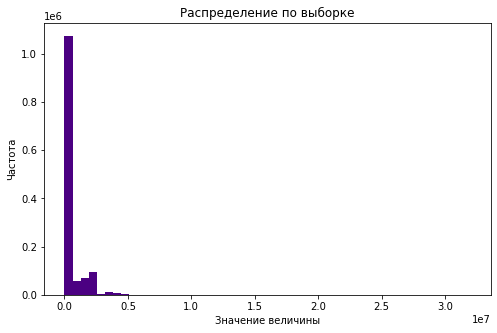

In [141]:
distribution(df.device_screen_resolution)

In [142]:
df.device_screen_resolution.value_counts(bins=100)

(-32000.001, 320000.0]      573585
(320000.0, 640000.0]        499224
(1920000.0, 2240000.0]       88540
(1280000.0, 1600000.0]       61484
(960000.0, 1280000.0]        33798
                             ...  
(18880000.0, 19200000.0]         0
(19520000.0, 19840000.0]         0
(19840000.0, 20160000.0]         0
(20160000.0, 20480000.0]         0
(16000000.0, 16320000.0]         0
Name: device_screen_resolution, Length: 100, dtype: int64

Сгруппируем категории так, чтобы было примерно равномерное распределение по категориям

In [143]:
len(df[df.device_screen_resolution < 300000])

448606

In [144]:
len(df[(df.device_screen_resolution >= 300000 ) & (df.device_screen_resolution <= 375000)])

524823

In [145]:
len(df[df.device_screen_resolution > 375000])

347273

In [146]:
def pixels_range(pixel):
    if pixel == 0:
        resolution = 'other'
    elif (pixel > 0) & (pixel < 300000):
        resolution = 'low'
    elif pixel > 375000:
        resolution = 'high'
    else:
        resolution = 'medium'

    return resolution

In [147]:
df.device_screen_resolution = df.device_screen_resolution.apply(pixels_range)

In [148]:
df.nunique()

utm_source                   252
utm_medium                    50
utm_campaign                 383
utm_adcontent                267
utm_keyword                 1143
device_category                3
device_os                     13
device_brand                 200
device_screen_resolution       4
device_browser                36
geo_country                  157
geo_city                    2327
dtype: int64

In [149]:
df.device_screen_resolution.value_counts()

medium    524823
low       448597
high      347273
other          9
Name: device_screen_resolution, dtype: int64

In [150]:
df.nunique()

utm_source                   252
utm_medium                    50
utm_campaign                 383
utm_adcontent                267
utm_keyword                 1143
device_category                3
device_os                     13
device_brand                 200
device_screen_resolution       4
device_browser                36
geo_country                  157
geo_city                    2327
dtype: int64

geo_city - преобразовать никак невозможно, потому как снижение количества уникальных значений сильно повлияет на модель
и этот признак станет бесполезным, так как сберавтоподписка работает в разных регионах этот параметр необходимо учитывать.
utm_keyword - ключевое слово тоже невозможно никак преобразовать
То есть дальнейшие преобразования категориальных признаков невозможны.

посчитаем размерность датасета после преобразования ohe

In [151]:
number_of_cat = 0
for col in df.columns:
    number_of_cat += df[col].unique().shape[0]
number_of_cat

4835

Размерность датасета после преобразования по прежнему огромная. Стандартными методами преобразовать датасет для моделирования
затруднительно. Модель может работать только с числовыми признаками.

### 3.2 - Признаки на основе дат

In [153]:
df_int = df_key_action.select_dtypes(include=['int']).copy()
df_int

,visit_hour,hit_day,hit_hour,visit_number,hit_number,hit_len_path
client_id,,,,,,
2.108461e+09,9,0,3,1,11,49
2.108465e+09,21,0,7,1,26,153
2.108467e+09,22,0,3,1,55,79
2.108521e+09,15,5,3,1,19,49
2.108536e+09,15,5,3,1,35,141
...,...,...,...,...,...,...
2.108378e+09,10,2,7,1,4,48
2.108380e+09,8,2,3,1,12,49
2.108380e+09,15,0,8,1,59,71


Вычислить разницу во времени не представляется возможным, попробуем запустить модель с такими фичами

### 3.3 - Стандартизация данных

In [161]:
list_df_int = df_int.columns.to_list()

In [162]:
list_df_int

['visit_hour',
 'hit_day',
 'hit_hour',
 'visit_number',
 'hit_number',
 'hit_len_path']

In [163]:
std_scaler = StandardScaler()
std_scaler.fit(df_int)
std_scaler = std_scaler.transform(df_int)
df_int[list_df_int] = std_scaler
df_int.head()

,visit_hour,hit_day,hit_hour,visit_number,hit_number,hit_len_path
client_id,,,,,,
2108460508.1623647,-0.737990,-1.411774,-0.447975,-0.17644,-0.009482,-0.361413
2108465203.1636395,1.207725,-1.411774,0.363042,-0.17644,0.969348,0.470912
2108466524.1624303,1.369868,-1.411774,-0.447975,-0.17644,2.861754,-0.121319
2108520872.1630156,0.234867,1.105719,-0.447975,-0.17644,0.512561,-0.361413
2108536037.1628945,0.234867,1.105719,-0.447975,-0.17644,1.556647,0.374874


In [166]:
df_model = pd.concat([df, df_int], axis = 1)

In [168]:
df_model['y'] = df_sessions_y['y']
df_model = df_model.sample(frac=1) # перемешаем
df_model

,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,visit_hour,hit_day,hit_hour,visit_number,hit_number,hit_len_path,y
client_id,,,,,,,,,,,,,,,,,,,
1976986692.1630728,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,PkybGvWbaqORmxjNunqZ,other,mobile,other,Huawei,low,Chrome,Russia,Moscow,-0.900133,1.105719,-0.447975,-0.176440,-0.596780,-0.577497,0.0
173487381.16369233,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,low,Safari,Russia,Saint Petersburg,0.072725,1.609217,1.985077,0.369585,0.447306,0.943096,0.0
1086707594.163376,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,other,mobile,other,Xiaomi,low,Chrome,Russia,Moscow,-0.737990,1.105719,-0.447975,-0.176440,-0.596780,-0.577497,0.0
2021263830.16249,MvfHsxITijuriZxsqZqt,cpv,FTjNLDyTrXaWYgZymFkV,PkybGvWbaqORmxjNunqZ,other,mobile,other,Samsung,medium,Samsung Internet,Russia,Moscow,1.045582,-1.411774,-0.447975,-0.176440,-0.596780,-0.577497,0.0
1488834317.16355,ZpYIoDJMcFzVoPFsHGJL,banner,gecBYcKZCPMcVYdSSzKP,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Samsung,medium,Chrome,Russia,Vladivostok,-0.251561,0.602220,-0.447975,-0.176440,0.316795,0.526934,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53489027.1630821372,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,PkybGvWbaqORmxjNunqZ,other,mobile,other,OPPO,low,Chrome,Russia,Saint Petersburg,-0.900133,1.609217,-0.447975,-0.176440,-0.531525,-0.577497,0.0
1571168433.1635025,fDLlAcSmythWSCVMvqvL,other,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,medium,Chrome,Russia,Moscow,-2.197276,1.609217,-0.042467,-0.176440,1.099859,-0.145329,0.0
1627825317.162464,ZpYIoDJMcFzVoPFsHGJL,banner,eimRuUrNhZLAYcwRrNXu,JNHcPlZPxEMWDnRiyoBf,other,mobile,other,Samsung,medium,Chrome,Russia,Moscow,0.883439,0.602220,-0.447975,-0.176440,-0.596780,-0.577497,0.0


In [169]:
df_model.to_csv('data/df.csv')

## 4 - Modelling

### 4.1 - Кодирование категориальных признаков для этапа моделирования

In [2]:
df_model = pd.read_csv('data/df.csv')
df_model

,client_id,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,visit_hour,hit_day,hit_hour,visit_number,hit_number,hit_len_path,y
0,1.976987e+09,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,PkybGvWbaqORmxjNunqZ,other,mobile,other,Huawei,low,Chrome,Russia,Moscow,-0.900133,1.105719,-0.447975,-0.176440,-0.596780,-0.577497,0.0
1,1.734874e+08,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,low,Safari,Russia,Saint Petersburg,0.072725,1.609217,1.985077,0.369585,0.447306,0.943096,0.0
2,1.086708e+09,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,other,mobile,other,Xiaomi,low,Chrome,Russia,Moscow,-0.737990,1.105719,-0.447975,-0.176440,-0.596780,-0.577497,0.0
3,2.021264e+09,MvfHsxITijuriZxsqZqt,cpv,FTjNLDyTrXaWYgZymFkV,PkybGvWbaqORmxjNunqZ,other,mobile,other,Samsung,medium,Samsung Internet,Russia,Moscow,1.045582,-1.411774,-0.447975,-0.176440,-0.596780,-0.577497,0.0
4,1.488834e+09,ZpYIoDJMcFzVoPFsHGJL,banner,gecBYcKZCPMcVYdSSzKP,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Samsung,medium,Chrome,Russia,Vladivostok,-0.251561,0.602220,-0.447975,-0.176440,0.316795,0.526934,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1320697,5.348903e+07,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,PkybGvWbaqORmxjNunqZ,other,mobile,other,OPPO,low,Chrome,Russia,Saint Petersburg,-0.900133,1.609217,-0.447975,-0.176440,-0.531525,-0.577497,0.0
1320698,1.571168e+09,fDLlAcSmythWSCVMvqvL,other,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,medium,Chrome,Russia,Moscow,-2.197276,1.609217,-0.042467,-0.176440,1.099859,-0.145329,0.0
1320699,1.627825e+09,ZpYIoDJMcFzVoPFsHGJL,banner,eimRuUrNhZLAYcwRrNXu,JNHcPlZPxEMWDnRiyoBf,other,mobile,other,Samsung,medium,Chrome,Russia,Moscow,0.883439,0.602220,-0.447975,-0.176440,-0.596780,-0.577497,0.0
1320700,6.130144e+08,ZpYIoDJMcFzVoPFsHGJL,banner,zxoiLxhuSIFrCeTLQVWZ,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Samsung,high,Chrome,Russia,Rostov-on-Don,1.045582,-0.908275,-0.447975,-0.176440,-0.531525,-0.577497,0.0


In [3]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320702 entries, 0 to 1320701
Data columns (total 20 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   client_id                 1320702 non-null  float64
 1   utm_source                1320702 non-null  object 
 2   utm_medium                1320702 non-null  object 
 3   utm_campaign              1320702 non-null  object 
 4   utm_adcontent             1320702 non-null  object 
 5   utm_keyword               1320702 non-null  object 
 6   device_category           1320702 non-null  object 
 7   device_os                 1320702 non-null  object 
 8   device_brand              1320702 non-null  object 
 9   device_screen_resolution  1320702 non-null  object 
 10  device_browser            1320702 non-null  object 
 11  geo_country               1320702 non-null  object 
 12  geo_city                  1320702 non-null  object 
 13  visit_hour                1

Применим нестандартное кодирование (вероятностный подход) для уменьшения размерности df и экономии памяти
Источник https://github.com/art-glazunov/Non-standard-categorical-encodings/blob/main/group_counts_and_entropy.ipynb

In [4]:
class EntropyCategoricalEmbedder:
    """Unsupervised categorical embedder based on group counts and entropy calculation

    fit - get dictionary for the transformation of categorical objects into embeddings 
    transform - map the dictionary onto your categorical dataset to get the embeddings
    """

    def __init__(self):
        self.substitute_dict = {} #resulting dictionary to transform the objects into embs

    def __repr__(self):
        return self.__class__.__name__ + "()"
    
    @staticmethod
    def cat_prep(data: pd.DataFrame) -> pd.DataFrame:
        """change category names for simplification

        format -> category-name_category-name
        """

        data_new = data.copy()
        for col in tqdm(data.columns):
            data_new[col] = data[col].apply(lambda x: col + '_' + str(x))
        return data_new
    
    def fit(self, df_train: pd.DataFrame, verbose: bool = True) -> EntropyCategoricalEmbedderObject: # we created this custom type earlier
        """Create dictionary to map on the dataset

        !!!Works only with categorical datasets!!!
        dataset - pandas DataFrame with only categorical columns in str format (after cat_prep) 
        (each row is our object to get an embedding for)
        """
        
        feature_list = list(df_train.columns)
        df = df_train.copy()
        df['id'] = df.index
        for group_key in tqdm(feature_list):    
            passive_keys = feature_list[:]
            passive_keys.remove(group_key)

            category_embedding_mapping = {}
            for passive_key in passive_keys:
                if verbose:
                    print('--- groupby: group_key - ', group_key, '### passive_key - ', passive_key, '---')                
                group = df.groupby([group_key, passive_key])['id'].count()
                group = group.unstack().fillna(0)
                entropy_values = group.apply(entropy, axis=1)
                for cat, entropy_value in entropy_values.to_dict().items():
                    if cat in category_embedding_mapping:
                        category_embedding_mapping[cat].extend([entropy_value]) 
                    else:
                        category_embedding_mapping[cat] = [entropy_value]
                
            self.substitute_dict[group_key] = category_embedding_mapping  
        return self

    def transform(self, dataset: pd.DataFrame, 
                  fill_unknown_cat_value: int = 0,
                  verbose: bool = False) -> List[list]:
        """Get embedding for each categorical row of the dataset

        !!!Works only with categorical datasets!!!
        dataset - pandas DataFrame with only categorical columns in str format (after cat_prep) 
        (each row is our object to get an embedding for)
        fill_unknown_cat_value - the value to fill embedding vector for unknown categories
        """

        dataset = dataset.copy()
        feature_list = list(dataset.columns)        
        emb_size = len(feature_list) - 1
        if verbose:
            print("Mapping vectors to categories...")
        for f in tqdm(feature_list):
            dataset[f] = dataset[f].map(self.substitute_dict[f])              
            dataset[f] = dataset[f].fillna('empty')
            dataset[f] = dataset[f].apply(lambda x: [fill_unknown_cat_value] * emb_size if x == 'empty' else x)
        
        embeddings_list = []
        if verbose:
            print("Creating an embedding for each row...")
        for row in tqdm(dataset[feature_list].itertuples()):
            embeddings_list.append(list(itertools.chain(*row[1:])))

        return embeddings_list

In [5]:
df_model = df_model.drop(['client_id'], axis=1)
x = df_model.drop(['y'], axis=1)
y = df_model['y']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [6]:
df_train = X_train.copy()
df_train = EntropyCategoricalEmbedder.cat_prep(df_train)
df_train.head()

  0%|          | 0/18 [00:00<?, ?it/s]

,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,visit_hour,hit_day,hit_hour,visit_number,hit_number,hit_len_path
953368,utm_source_ZpYIoDJMcFzVoPFsHGJL,utm_medium_banner,utm_campaign_LEoPHuyFvzoNfnzGgfcd,utm_adcontent_vCIpmpaGBnIQhyYNkXqp,utm_keyword_puhZPIYqKXeFPaUviSjo,device_category_mobile,device_os_iOS,device_brand_Apple,device_screen_resolution_low,device_browser_Safari,geo_country_Russia,geo_city_Kursk,visit_hour_0.0727245572228389,hit_day_1.6092169226041309,hit_hour_-0.4479752365028287,visit_number_0.3695850384303453,hit_number_-0.5967802233746009,hit_len_path_-0.2333630469666492
498945,utm_source_ZpYIoDJMcFzVoPFsHGJL,utm_medium_banner,utm_campaign_LEoPHuyFvzoNfnzGgfcd,utm_adcontent_vCIpmpaGBnIQhyYNkXqp,utm_keyword_puhZPIYqKXeFPaUviSjo,device_category_mobile,device_os_Android,device_brand_Xiaomi,device_screen_resolution_low,device_browser_Chrome,geo_country_Russia,geo_city_Lipetsk,visit_hour_0.0727245572228389,hit_day_-1.4117735609909123,hit_hour_-0.8534838913693318,visit_number_-0.1764396807892797,hit_number_0.8388376589041356,hit_len_path_0.8230494600662827
384064,utm_source_kjsLglQLzykiRbcDiGcD,utm_medium_cpc,utm_campaign_bJJuEXRheRIxXEaYIXqM,utm_adcontent_JNHcPlZPxEMWDnRiyoBf,utm_keyword_other,device_category_desktop,device_os_other,device_brand_Apple,device_screen_resolution_high,device_browser_Chrome,geo_country_Russia,geo_city_Moscow,visit_hour_-2.0351334390617524,hit_day_1.1057185086716237,hit_hour_-0.4479752365028287,visit_number_-0.1764396807892797,hit_number_-0.5315248650892038,hit_len_path_-0.5534880490978407
1192269,utm_source_kjsLglQLzykiRbcDiGcD,utm_medium_cpc,utm_campaign_mIKayglJaKQZvgdtLfqT,utm_adcontent_JNHcPlZPxEMWDnRiyoBf,utm_keyword_other,device_category_desktop,device_os_other,device_brand_Apple,device_screen_resolution_high,device_browser_Chrome,geo_country_Russia,geo_city_Moscow,visit_hour_1.0455820939695737,hit_day_0.0987216808066093,hit_hour_-0.4479752365028287,visit_number_-0.1764396807892797,hit_number_-0.5967802233746009,hit_len_path_-0.57749742425768
424758,utm_source_ZpYIoDJMcFzVoPFsHGJL,utm_medium_banner,utm_campaign_LEoPHuyFvzoNfnzGgfcd,utm_adcontent_JNHcPlZPxEMWDnRiyoBf,utm_keyword_other,device_category_mobile,device_os_other,device_brand_Apple,device_screen_resolution_medium,device_browser_Safari,geo_country_Ukraine,geo_city_Simferopol,visit_hour_-0.7379900567327732,hit_day_-0.4047767331258979,hit_hour_-0.4479752365028287,visit_number_-0.1764396807892797,hit_number_-0.4662695068038067,hit_len_path_-0.57749742425768


In [7]:
df_test = X_test.copy()
df_test = EntropyCategoricalEmbedder.cat_prep(df_test)
df_test.head()

  0%|          | 0/18 [00:00<?, ?it/s]

,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,visit_hour,hit_day,hit_hour,visit_number,hit_number,hit_len_path
338116,utm_source_fDLlAcSmythWSCVMvqvL,utm_medium_other,utm_campaign_LTuZkdKfxRGVceoWkVyg,utm_adcontent_JNHcPlZPxEMWDnRiyoBf,utm_keyword_puhZPIYqKXeFPaUviSjo,device_category_mobile,device_os_Android,device_brand_Xiaomi,device_screen_resolution_low,device_browser_Chrome,geo_country_Ukraine,geo_city_Kyiv,visit_hour_-0.5758471339416508,hit_day_-0.4047767331258979,hit_hour_-0.4479752365028287,visit_number_-0.1764396807892797,hit_number_-0.5315248650892038,hit_len_path_-0.57749742425768
590353,utm_source_PlbkrSYoHuZBWfYjYnfw,utm_medium_cpm,utm_campaign_izpGVnqOrUbTVctFBiaU,utm_adcontent_JNHcPlZPxEMWDnRiyoBf,utm_keyword_other,device_category_mobile,device_os_other,device_brand_Xiaomi,device_screen_resolution_medium,device_browser_Chrome,geo_country_Russia,geo_city_Moscow,visit_hour_-0.9001329795238956,hit_day_1.6092169226041309,hit_hour_-0.4479752365028287,visit_number_-0.1764396807892797,hit_number_-0.5315248650892038,hit_len_path_-0.2493692970732087
26693,utm_source_QxAxdyPLuQMEcrdZWdWb,utm_medium_cpm,utm_campaign_EiQppLFrUZrUsjXVulLg,utm_adcontent_JNHcPlZPxEMWDnRiyoBf,utm_keyword_other,device_category_mobile,device_os_other,device_brand_Huawei,device_screen_resolution_low,device_browser_Android Webview,geo_country_Russia,geo_city_Krasnogorsk,visit_hour_1.3698679395518183,hit_day_-1.4117735609909123,hit_hour_-0.4479752365028287,visit_number_-0.1764396807892797,hit_number_0.3167947926209586,hit_len_path_0.3828775821358944
145537,utm_source_PlbkrSYoHuZBWfYjYnfw,utm_medium_cpm,utm_campaign_FTjNLDyTrXaWYgZymFkV,utm_adcontent_TuyPWsGQruPMpKvRxeBF,utm_keyword_other,device_category_desktop,device_os_other,device_brand_Apple,device_screen_resolution_high,device_browser_Chrome,geo_country_Russia,geo_city_other,visit_hour_-1.87299051627063,hit_day_1.6092169226041309,hit_hour_-0.4479752365028287,visit_number_-0.1764396807892797,hit_number_-0.5315248650892038,hit_len_path_-0.57749742425768
870427,utm_source_ZpYIoDJMcFzVoPFsHGJL,utm_medium_banner,utm_campaign_gecBYcKZCPMcVYdSSzKP,utm_adcontent_JNHcPlZPxEMWDnRiyoBf,utm_keyword_other,device_category_mobile,device_os_other,device_brand_Apple,device_screen_resolution_low,device_browser_Safari,geo_country_Russia,geo_city_Kirov,visit_hour_-0.2515612883594059,hit_day_1.1057185086716237,hit_hour_-0.4479752365028287,visit_number_-0.1764396807892797,hit_number_0.3820501509063558,hit_len_path_0.6709900840539668


In [8]:
embedder = EntropyCategoricalEmbedder()
embedder

EntropyCategoricalEmbedder()

In [9]:
%%time
embedder.fit(df_train, verbose=False)

  0%|          | 0/18 [00:00<?, ?it/s]

Wall time: 1min 17s


EntropyCategoricalEmbedder()

In [10]:
%%time
train_feat = embedder.transform(df_train)

  0%|          | 0/18 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Wall time: 29.2 s


In [11]:
%%time
test_feat = embedder.transform(df_test)

  0%|          | 0/18 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Wall time: 17.5 s


In [12]:
np.array(test_feat)

array([[0.        , 0.        , 0.        , ..., 1.00939291, 0.51406202,
        2.07621237],
       [0.        , 0.42195574, 0.34638126, ..., 1.66436418, 0.69101655,
        3.35791614],
       [0.56725939, 2.97750112, 0.0243296 , ..., 0.32516264, 0.57900219,
        3.70062774],
       ...,
       [0.26750332, 1.36998036, 0.71129988, ..., 1.00939291, 0.51406202,
        2.07621237],
       [0.09077248, 1.54768925, 1.25736656, ..., 0.32406066, 0.74613489,
        3.57043808],
       [0.        , 0.        , 0.        , ..., 0.18616809, 0.19981816,
        2.27292738]])

In [13]:
np.array(test_feat).shape

(396211, 306)

размерность данных уменьшилось в ширину до 306 признаков

### 4.2 - Выбор модели машинного обучения

логисчитеская регрессия

In [14]:
%%time
lr_pipe = Pipeline([('scaler', StandardScaler()),
                      ('classifier', LogisticRegression())])
lr_pipe.fit(train_feat, y_train)

Wall time: 2min 12s


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', LogisticRegression())])

In [15]:
probs = lr_pipe.predict_proba(test_feat)
score_lr_scaled = roc_auc_score(y_test, probs[:, 1])
print(score_lr_scaled)

0.8710359665143537


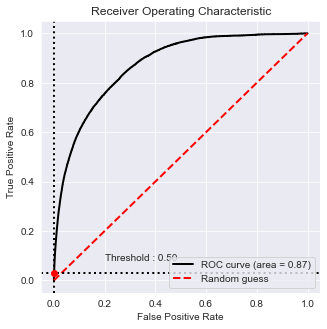

In [16]:
bc = BinaryClassification(y_test, probs[:, 1], labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

ROC-AUC > 0.65, задача выполнена. Обучим другие модели классификации

In [17]:
predict_lr = lr_pipe.predict(test_feat)
accuracy = accuracy_score(y_test, predict_lr)
print(accuracy)

0.9671160063703431


In [18]:
confusion_matrix(y_test, predict_lr)

array([[382801,    276],
       [ 12753,    381]], dtype=int64)

Многоуровневый классификатор Perceptron

In [21]:
%%time
perp_pipe = Pipeline([('scaler', StandardScaler()),
                      ('classifier', MLPClassifier())])
perp_pipe.fit(train_feat, y_train)
probs_perp = perp_pipe.predict_proba(test_feat)
score_perp_scaled = roc_auc_score(y_test, probs_perp[:, 1])
print(score_perp_scaled)

0.9120041137175163
Wall time: 1h 4min 57s


In [46]:
score_perp_scaled = roc_auc_score(y_test, probs_perp[:, 1])
print(score_perp_scaled)

0.9120041137175163


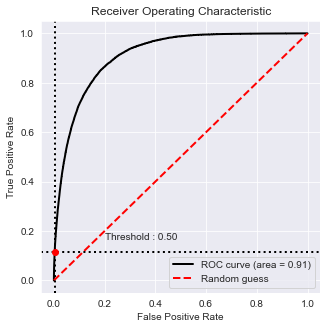

In [23]:
bc_perp = BinaryClassification(y_test, probs_perp[:, 1], labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc_perp.plot_roc_curve()
plt.show()

Персептрон лучше всех показал себя. ROC-AUC = 0.91.

In [24]:
predict = perp_pipe.predict(test_feat)
accuracy = accuracy_score(y_test, predict)
print(accuracy)

0.9675248794203088


In [25]:
confusion_matrix(y_test, predict)

array([[381816,   1261],
       [ 11606,   1528]], dtype=int64)

In [26]:
def qwerty(q, k):
    for i in range(0, len(q)):
        if q[i] < k:
            q[i] = 0
        else:
            q[i] = 1
    return q

In [47]:
q = probs_perp[:, 1].copy()
qwerty(q, 0.045)
confusion_matrix(y_test, q)

array([[329940,  53137],
       [  2810,  10324]], dtype=int64)